In [2]:
library("ridge")
library("sva")
library("car")
library("preprocessCore")
library("ROCR")
library("GEOquery")
source("../../../Geeleher_with_GDSCr6/scripts/compute_phenotype_function.R")
source("../../../Geeleher_with_GDSCr6/scripts/summarizeGenesByMean.R")
source("../../../Geeleher_with_GDSCr6/scripts/homogenize_data.R")
source("../../../Geeleher_with_GDSCr6/scripts/do_variable_selection.R")



from bortezomib_GDSCr6.R provied by Lukas Folkman with changes 

# Changes:
1) duplicated genes excluded

2) R2R6CCL=FALSE - on all GDSCr6 cell lines


3) No power Transform - powTransP=FALSE

In [3]:
# You can play with the preprocessing but the following is what Geeleher et al. 2014 used:
powTransP=TRUE
lowVarGeneThr=0.2
# Number of permutations <---- not used  
NUM_PERM=10000



In [4]:
group_compare_plot <- function(predictedResp,knownRespGroups, 
                        plot_title="",plot_ylab="logIC50",cohort=""){
    # predictedResp is a list of predicted IC50 with sample names in names
    # knownRespGroups is a table with samples in rownames and column "response" with R and S
    R_samples <- row.names(knownRespGroups[knownRespGroups["response"] == "R",])
    S_samples <-  row.names(knownRespGroups[knownRespGroups["response"] == "S",])

    predictedRespGrouped <- list("Resistant"=predictedResp[R_samples],
                                  "Sensitive"=predictedResp[S_samples]) 
    
    boxplot(predictedRespGrouped, outline=FALSE, border="grey", 
            ylab="logIC50",
            main=plot_title)
    stripchart(predictedRespGrouped , vertical=TRUE, pch=20, method="jitter", add=TRUE)
    # T-test whether logIC50 in R is greater than in S group
    #ttest_res <- t.test(predictedRespGrouped$"Resistant",predictedRespGrouped$"Sensitive", alternative="greater")
    #cat(cohort,"\n\tT-test p-value:", ttest_res$p.value,
    #"\n\tCI95%:",ttest_res$conf.int,
    #"\n\tmeans:",ttest_res$estimate,"\n")
    return (predictedRespGrouped)
}

getAUC <- function(predictedRespGrouped,NUM_PERM=1000){
    # calculate AUC on the real data 
    predictedResp <- c(predictedRespGrouped$"Sensitive",predictedRespGrouped$"Resistant")
    
    trueResp <- c(rep("Sensitive", length(predictedRespGrouped$"Sensitive")), 
                  rep("Resistant", length(predictedRespGrouped$"Resistant")))
    
    predictionResult <- prediction(predictedResp, trueResp, label.ordering=c("Sensitive", "Resistant"))
    
    performanceObj <- performance(predictionResult, measure = "tpr", x.measure = "fpr")
    realDataAUC <- performance(predictionResult, measure = "auc")@"y.values"[[1]]
    cat(paste0("\nAUC:    ", realDataAUC,"\n"))
    
    # permute true response labels NUM_PERM and calculate AUCs
    AUCs <- numeric()
    for(i in 1:NUM_PERM)
    {
      # permute response labels
      permutedTrueResp <- sample(trueResp)
      predPerm <- prediction(predictedResp,permutedTrueResp,label.ordering=c("Sensitive", "Resistant"))
      AUCs[i] <- performance(predPerm, measure = "auc")@"y.values"[[1]]
    }
    permutationPvalue <- sum(AUCs  > realDataAUC)/NUM_PERM
    cat(paste0("ROC Permuatation p-value:    ", permutationPvalue,"\n"))
    cat(paste0("average AUC in permutations:    ", mean(AUCs),"\n"))
    return(performanceObj)
}

run_Geelehers_method <- function(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                       powTransP=TRUE,lowVarGeneThr=0.2,cohort=cohort,drug=drug){
    # read training data and reorder 
    trainingData <- read.csv(trainingDataFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingResponse <- read.csv(trainingResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingData <- as.matrix(trainingData[,row.names(trainingResponse)])
    #trainingData <- 2^trainingData
    trainingI50 <- trainingResponse$logIC50
    names(trainingI50 ) <- rownames(trainingResponse)
    
    
    # read testing data and reorder 
    testData <- read.table(testDataFile,sep = "\t", row.names = 1, header= TRUE,as.is=TRUE, check.names=FALSE)
    testResponse <- read.csv(testResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    testData <- as.matrix(testData[,row.names(testResponse)])
    #testData <- 2^testData
    
    # statistics
    shared_genes = intersect(row.names(trainingData),row.names(testData))
    cat(paste0(cohort," ",drug,"\n"))
    cat(paste0("genes in training cohort: ", dim(trainingData)[1],"\tsamples: ", dim(trainingData)[2],"\n",
               "genes in testing cohort: ", dim(testData)[1],"\tsamples: ", dim(testData)[2],"\n",
               "shared:", length(shared_genes),"\n"))
    
    # predict response for testing cohort
    sink("/dev/null") 
    predictedIC50 <- suppressMessages(calcPhenotype(testData, trainingData, trainingI50,
                               powerTransformPhenotype=powTransP,
                               removeLowVaryingGenes=lowVarGeneThr,minNumSamples=2))
    sink()
    
    options(repr.plot.width=15, repr.plot.height=5)
    par(mfrow=c(1,3))

    sink("/dev/null") 
    tmp<-group_compare_plot(trainingI50,trainingResponse, 
                plot_title=paste0("Training: ","GDSC"),cohort = "GDSC")
    sink()
    tmp <-0
    
    # testing 
    predictedRespGrouped <- group_compare_plot(predictedIC50,testResponse, 
                plot_title=paste0("Prediction: ",cohort),cohort = cohort)

    # ROC curve and AUC
    performanceObj  <- getAUC(predictedRespGrouped,NUM_PERM=NUM_PERM)
    plot(performanceObj, main=paste0("ROC ","for ",drug," in ",cohort))
    abline(0, 1, col="grey", lty=2)
    cat("\n\n")
    #return (list("testExprs"=testData,"testResp"=testResponse, 
    #                "trainingExprs"=trainingData,"trainingResp"=trainingResponse))
} 



[1] "GSE18864"  "Cisplatin"
GSE18864 Cisplatin
genes in training cohort: 18645	samples: 829
genes in testing cohort: 20342	samples: 24
shared:17088

AUC:    0,5546875
ROC Permuatation p-value:    0,3287
average AUC in permutations:    0,5008734375


[1] "GSE25065"  "Docetaxel"
GSE25065 Docetaxel
genes in training cohort: 18645	samples: 829
genes in testing cohort: 12249	samples: 51
shared:11820

AUC:    0,565217391304348
ROC Permuatation p-value:    0,3189
average AUC in permutations:    0,502016086956522


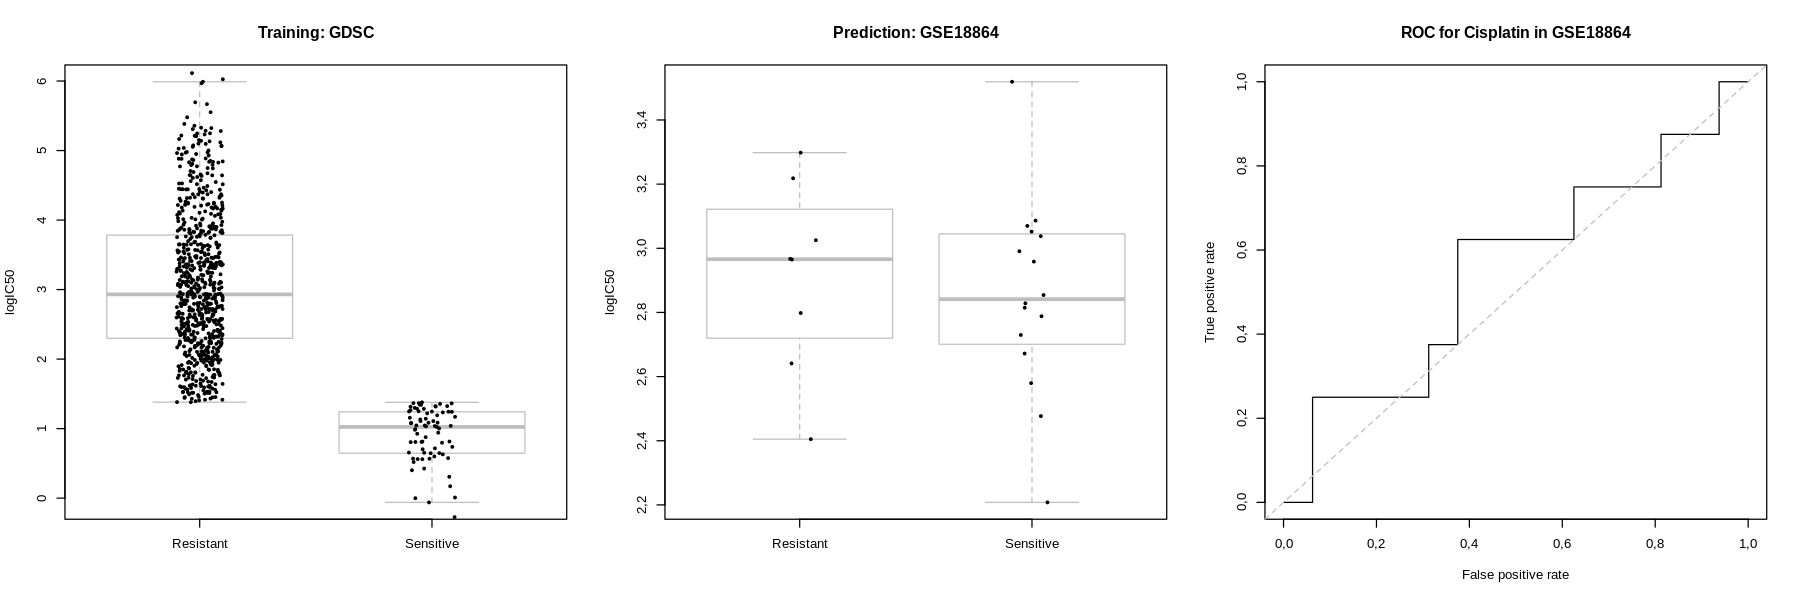



[1] "GSE25065"   "Paclitaxel"
GSE25065 Paclitaxel
genes in training cohort: 18645	samples: 389
genes in testing cohort: 12249	samples: 84
shared:11820

AUC:    0,630636604774536
ROC Permuatation p-value:    0,0257
average AUC in permutations:    0,499601724137931


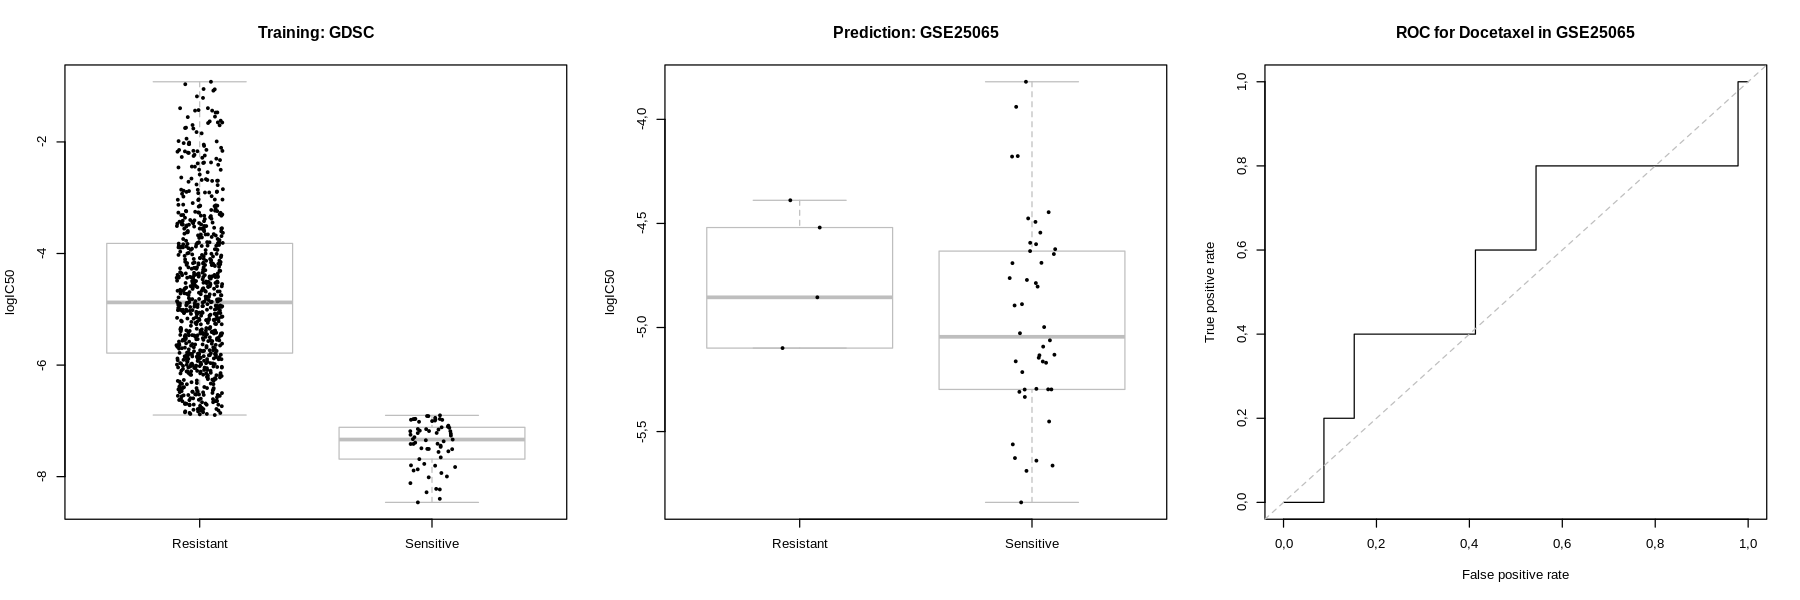



[1] "GSE33072"  "Erlotinib"
GSE33072 Erlotinib
genes in training cohort: 18645	samples: 362
genes in testing cohort: 20662	samples: 25
shared:18064

AUC:    0,58974358974359
ROC Permuatation p-value:    0,2162
average AUC in permutations:    0,49886282051282


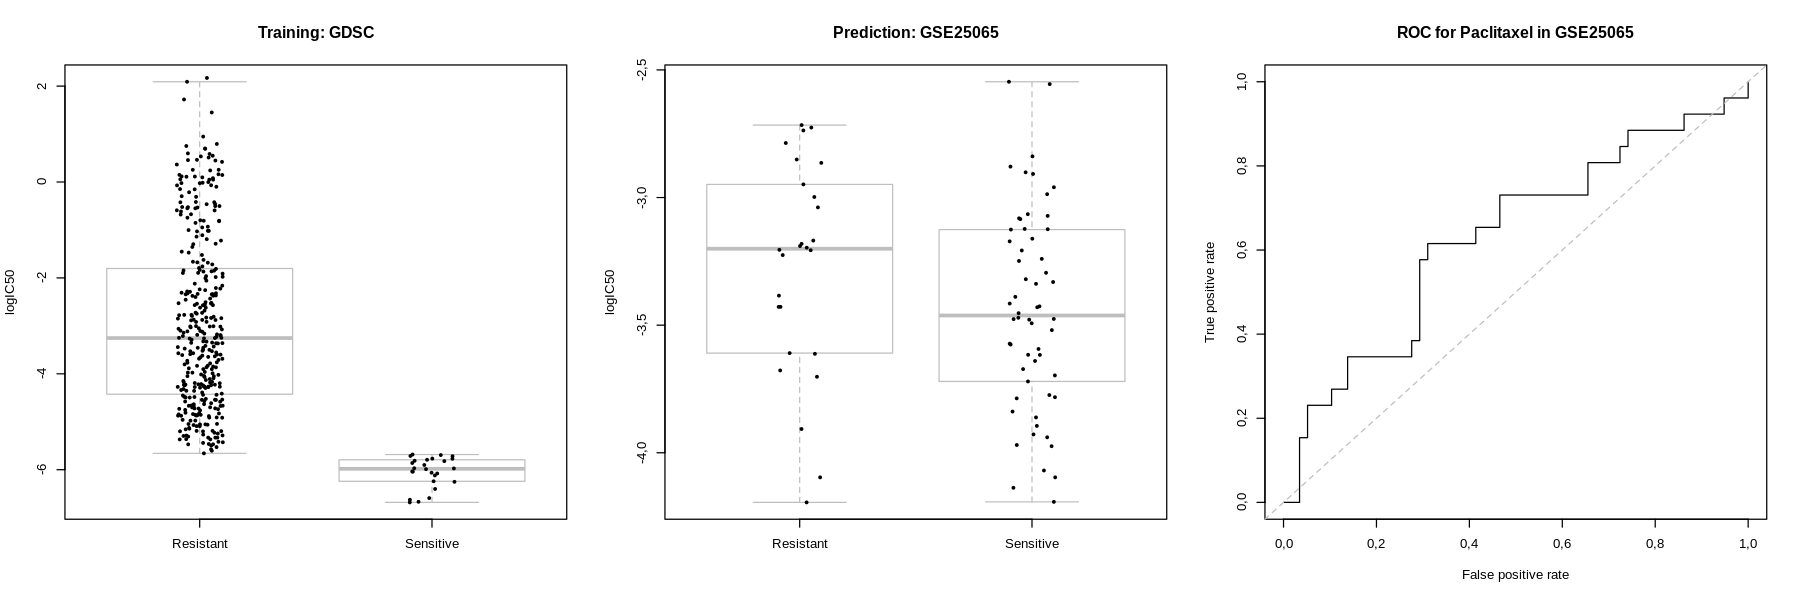



[1] "GSE6434"   "Docetaxel"
GSE6434 Docetaxel
genes in training cohort: 18645	samples: 829
genes in testing cohort: 8449	samples: 24
shared:8257

AUC:    0,557142857142857
ROC Permuatation p-value:    0,3164
average AUC in permutations:    0,501813571428571


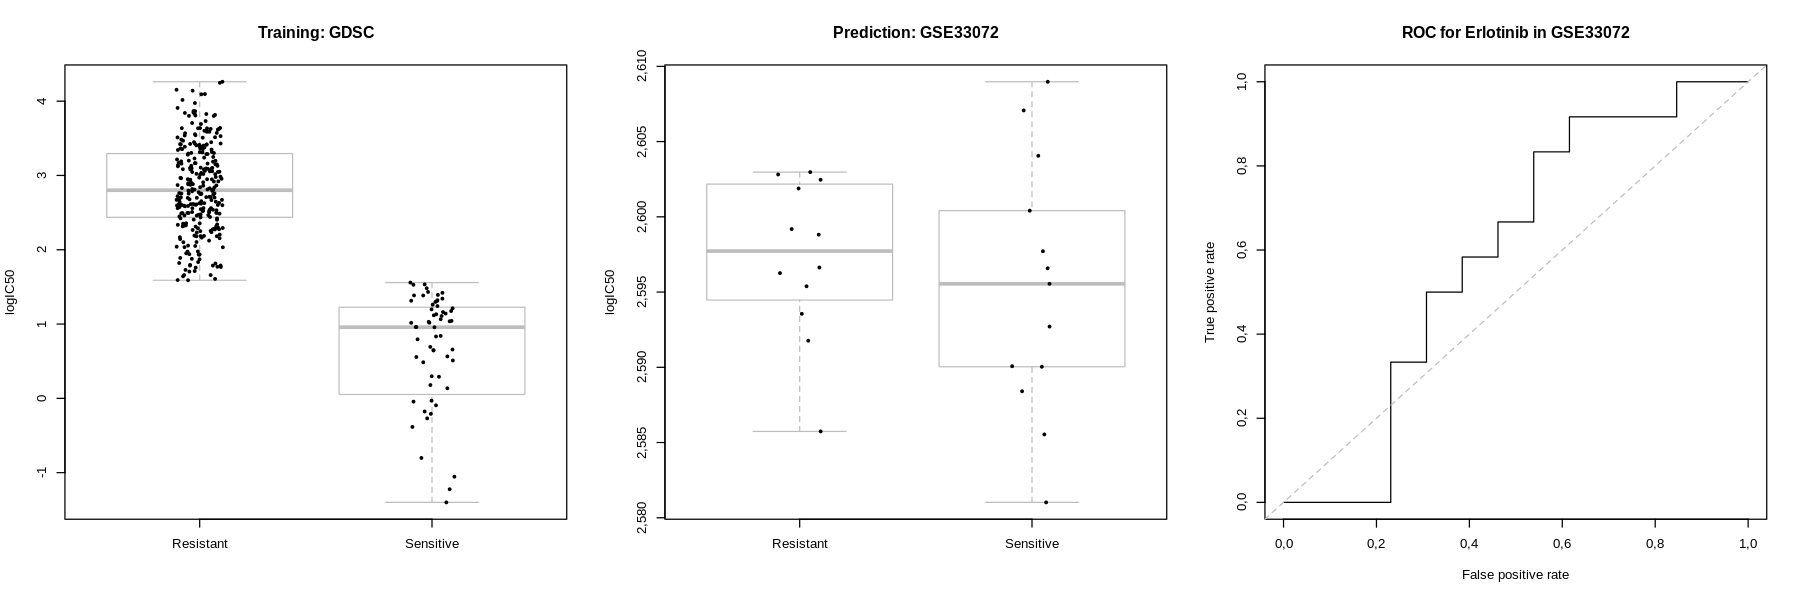



[1] "GSE9782-GPL96" "Bortezomib"   
GSE9782-GPL96 Bortezomib
genes in training cohort: 18645	samples: 391
genes in testing cohort: 12518	samples: 169
shared:11636

AUC:    0,47843137254902
ROC Permuatation p-value:    0,6814
average AUC in permutations:    0,499739131652661


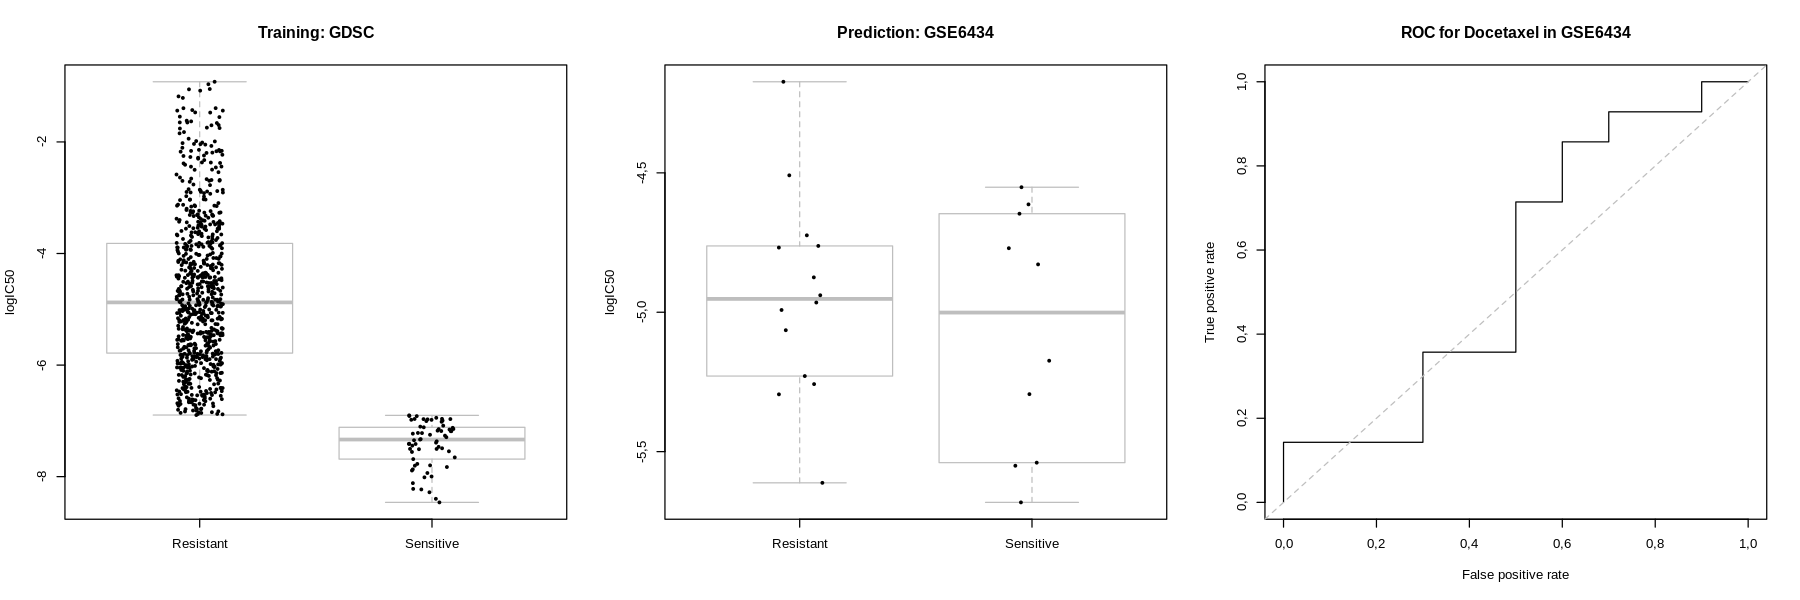



[1] "GSE9782-GPL97" "Bortezomib"   
GSE9782-GPL97 Bortezomib
genes in training cohort: 18645	samples: 391
genes in testing cohort: 9132	samples: 169
shared:7752

AUC:    0,516806722689076
ROC Permuatation p-value:    0,3585
average AUC in permutations:    0,500436330532213


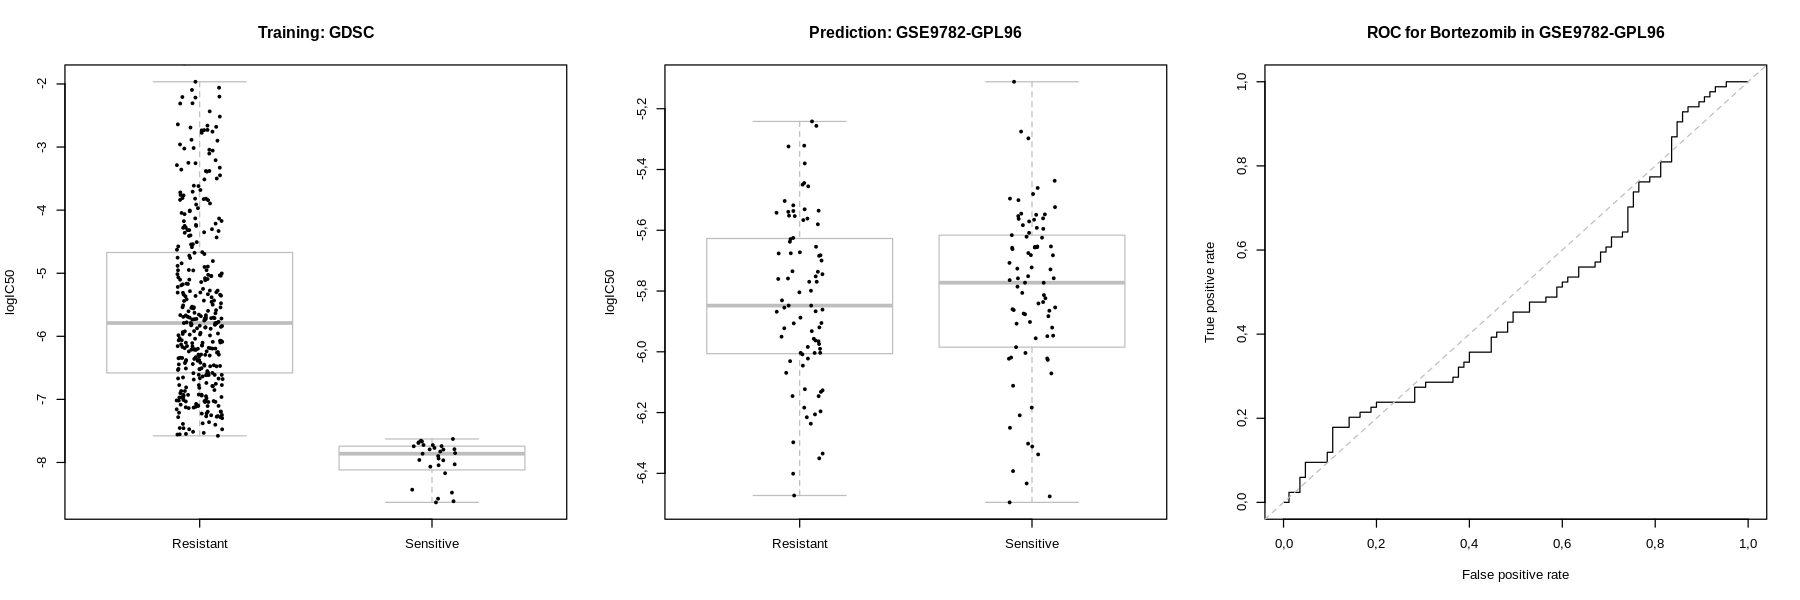



[1] "PDX"            "5-Fluorouracil"
PDX 5-Fluorouracil
genes in training cohort: 18645	samples: 889
genes in testing cohort: 22443	samples: 23
shared:18232

AUC:    0,863636363636364
ROC Permuatation p-value:    0,1297
average AUC in permutations:    0,50275


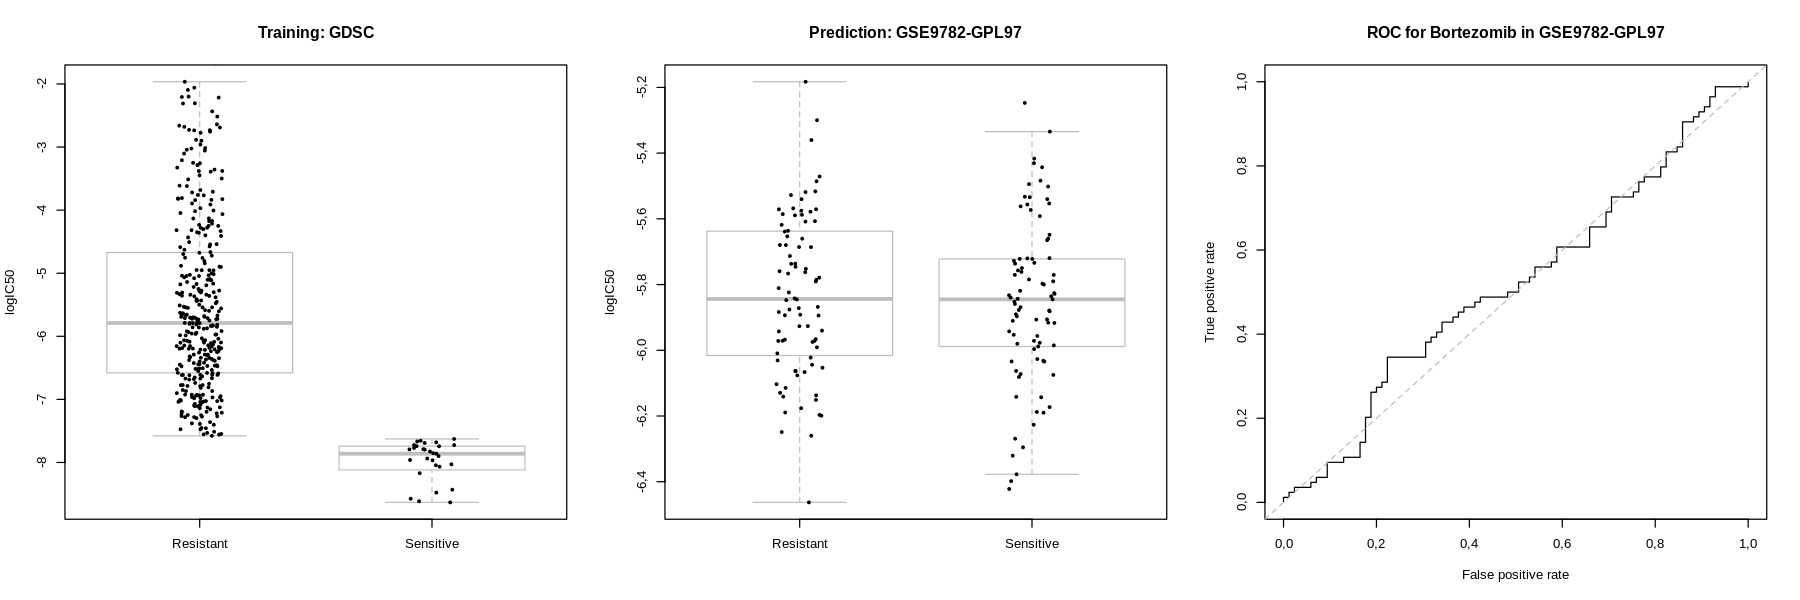



[1] "PDX"       "Cetuximab"
PDX Cetuximab
genes in training cohort: 18645	samples: 856
genes in testing cohort: 22443	samples: 60
shared:18232

AUC:    0,596363636363636
ROC Permuatation p-value:    0,2486
average AUC in permutations:    0,501894545454545


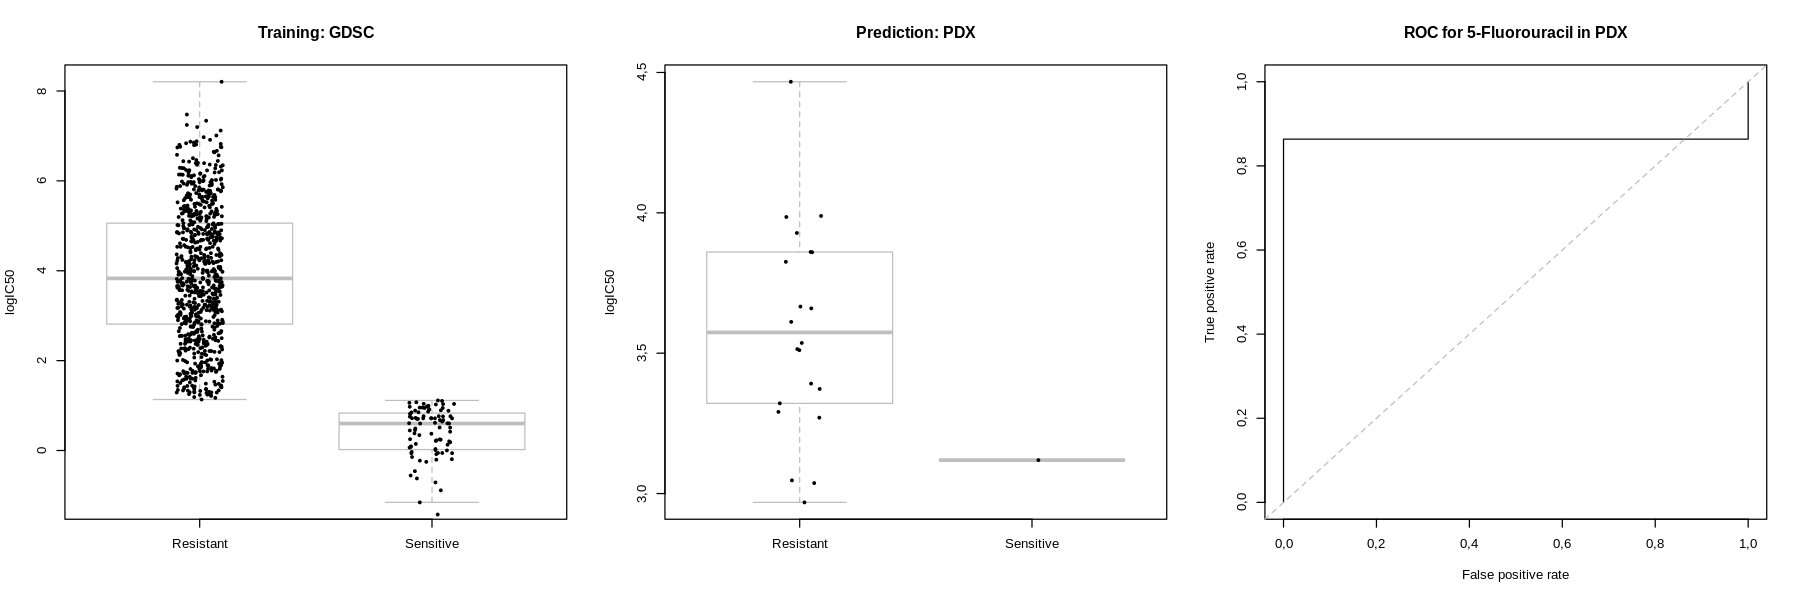



[1] "PDX"       "Erlotinib"
PDX Erlotinib
genes in training cohort: 18645	samples: 362
genes in testing cohort: 22443	samples: 21
shared:18232

AUC:    0,666666666666667
ROC Permuatation p-value:    0,1774
average AUC in permutations:    0,499431481481481


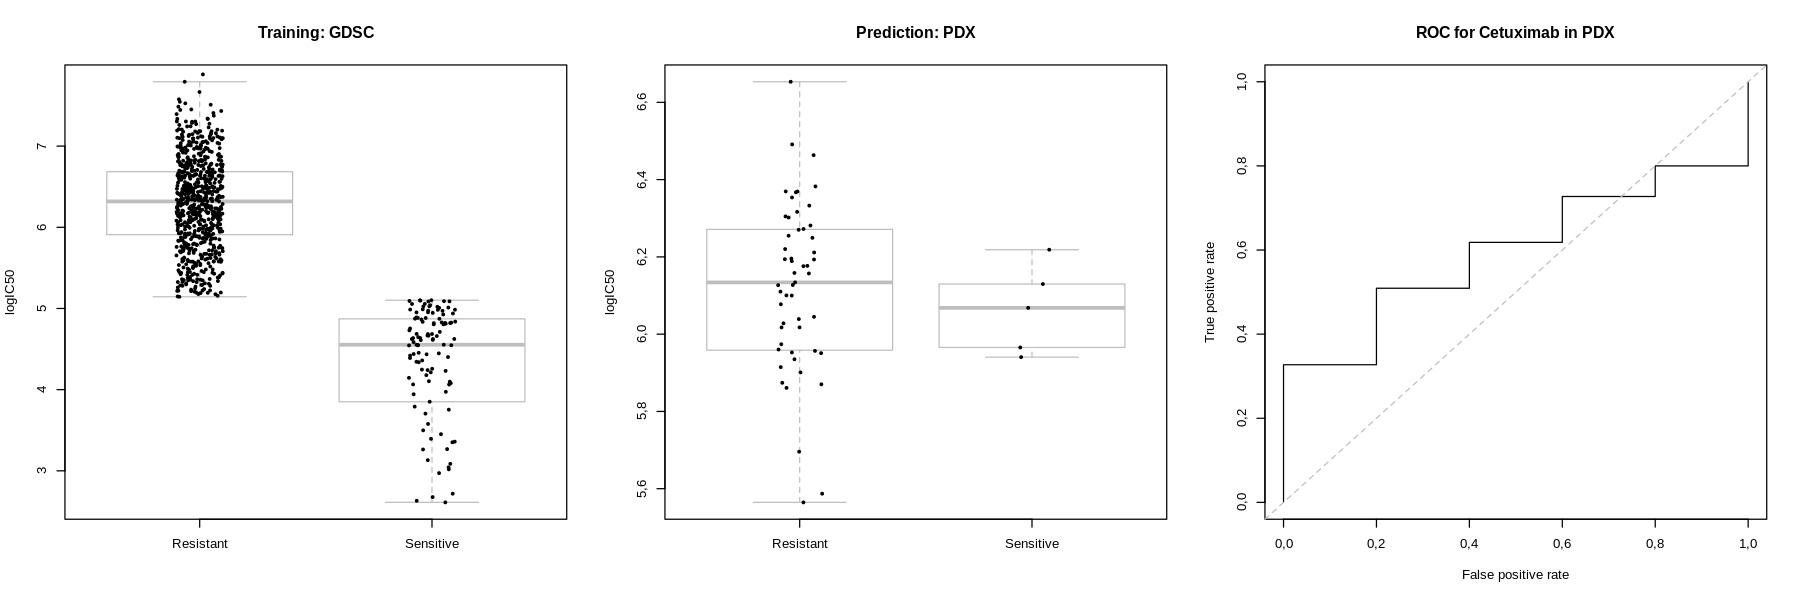



[1] "PDX"         "Gemcitabine"
PDX Gemcitabine
genes in training cohort: 18645	samples: 844
genes in testing cohort: 22443	samples: 25
shared:18232

AUC:    0,587301587301587
ROC Permuatation p-value:    0,255
average AUC in permutations:    0,500177777777778


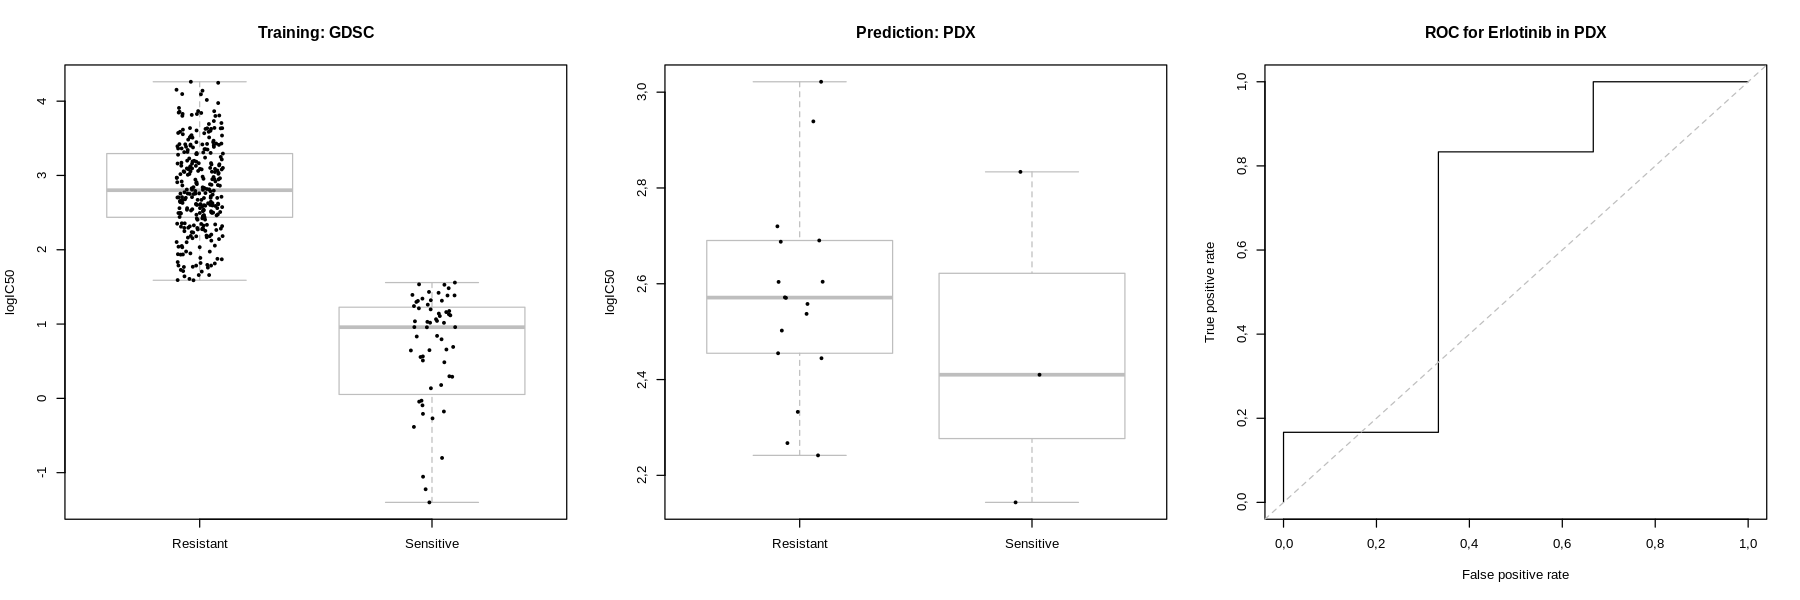



[1] "PDX"        "Paclitaxel"
PDX Paclitaxel
genes in training cohort: 18645	samples: 389
genes in testing cohort: 22443	samples: 43
shared:18232

AUC:    0,515789473684211
ROC Permuatation p-value:    0,4531
average AUC in permutations:    0,500325789473684


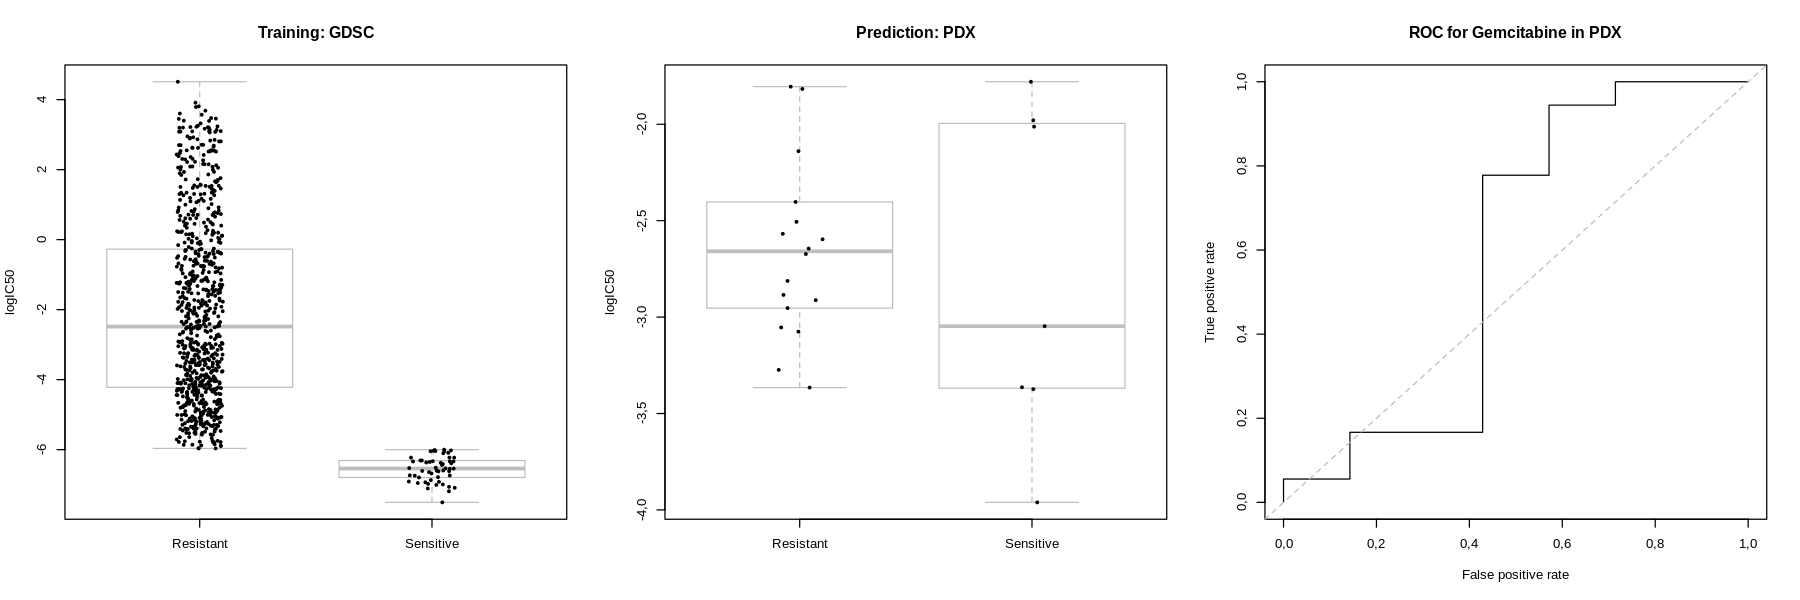



[1] "TCGA"      "Cetuximab"
TCGA Cetuximab
genes in training cohort: 18645	samples: 856
genes in testing cohort: 20531	samples: 10
shared:18216

AUC:    0,291666666666667
ROC Permuatation p-value:    0,8238
average AUC in permutations:    0,502220833333333


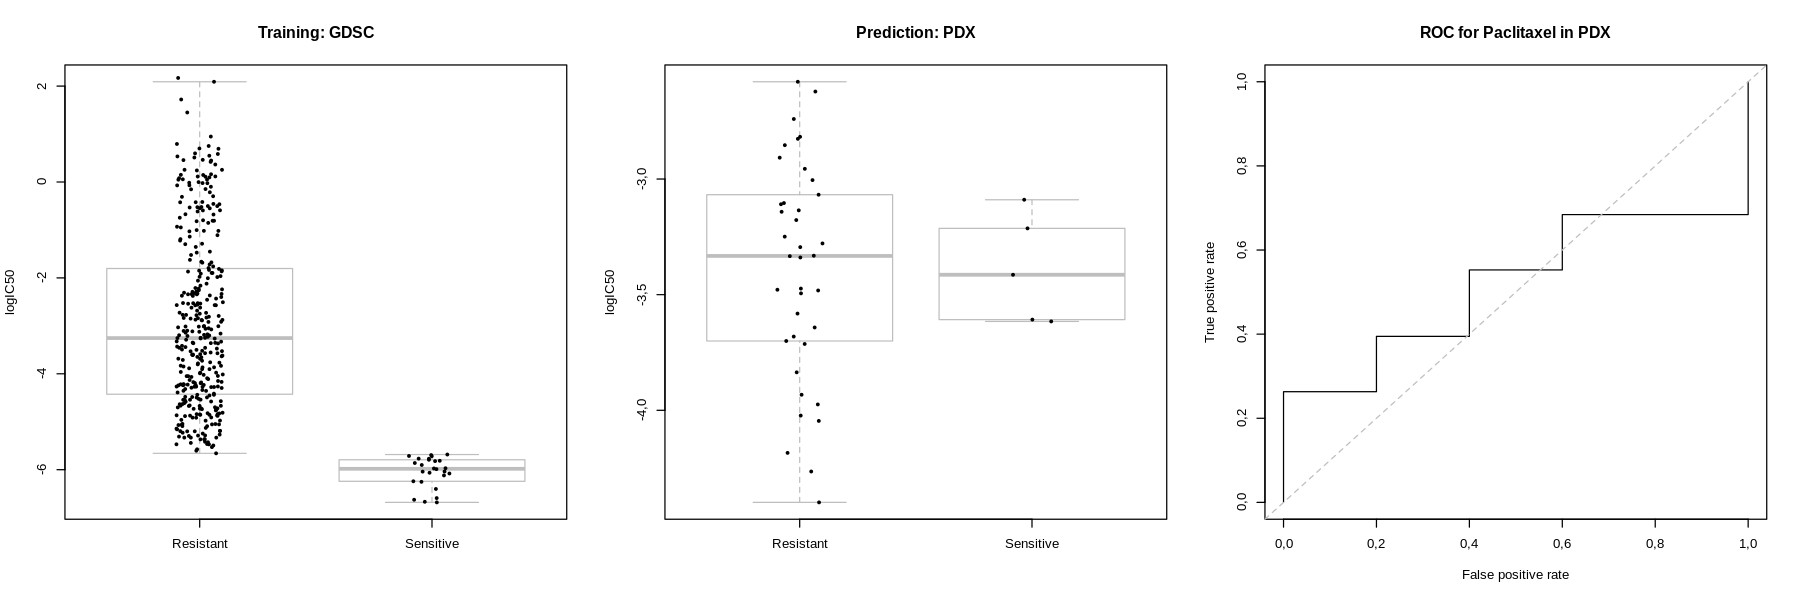



[1] "TCGA"      "Cisplatin"
TCGA Cisplatin
genes in training cohort: 18645	samples: 829
genes in testing cohort: 20531	samples: 66
shared:18216

AUC:    0,622222222222222
ROC Permuatation p-value:    0,1744
average AUC in permutations:    0,501375833333333


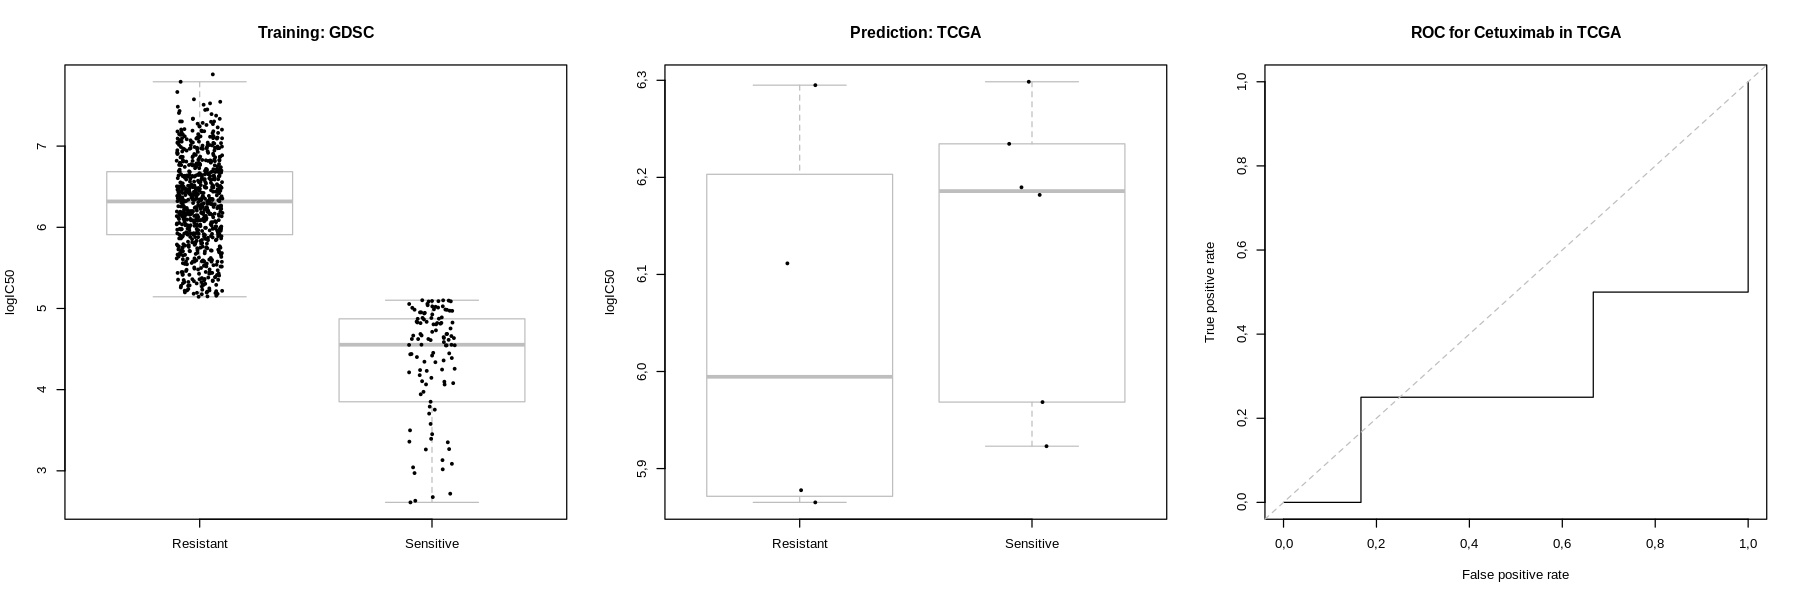



[1] "TCGA"      "Docetaxel"
TCGA Docetaxel
genes in training cohort: 18645	samples: 829
genes in testing cohort: 20531	samples: 16
shared:18216

AUC:    0,59375
ROC Permuatation p-value:    0,2521
average AUC in permutations:    0,4993171875


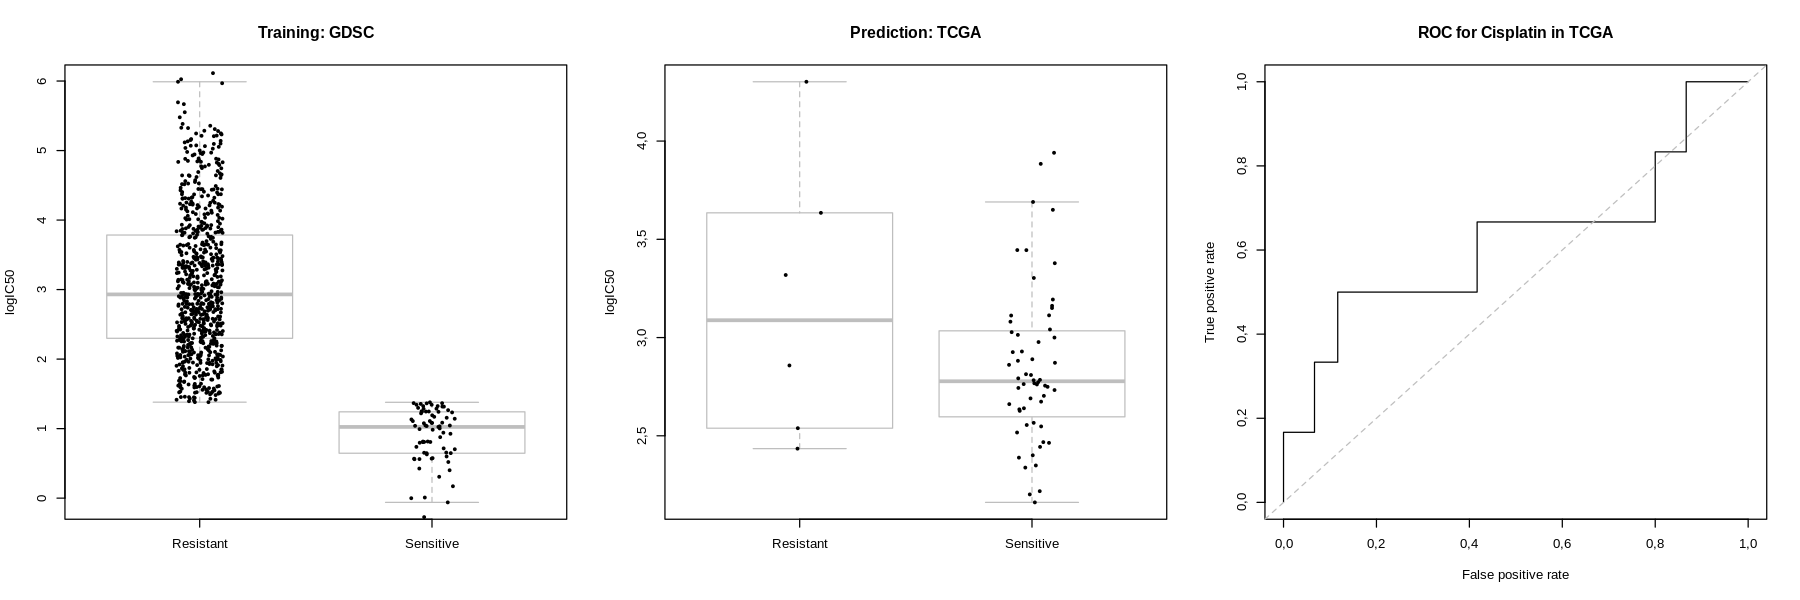



[1] "TCGA"      "Erlotinib"
TCGA Erlotinib
genes in training cohort: 18645	samples: 362
genes in testing cohort: 20531	samples: 3
shared:18216

AUC:    0
ROC Permuatation p-value:    0,6675
average AUC in permutations:    0,5025


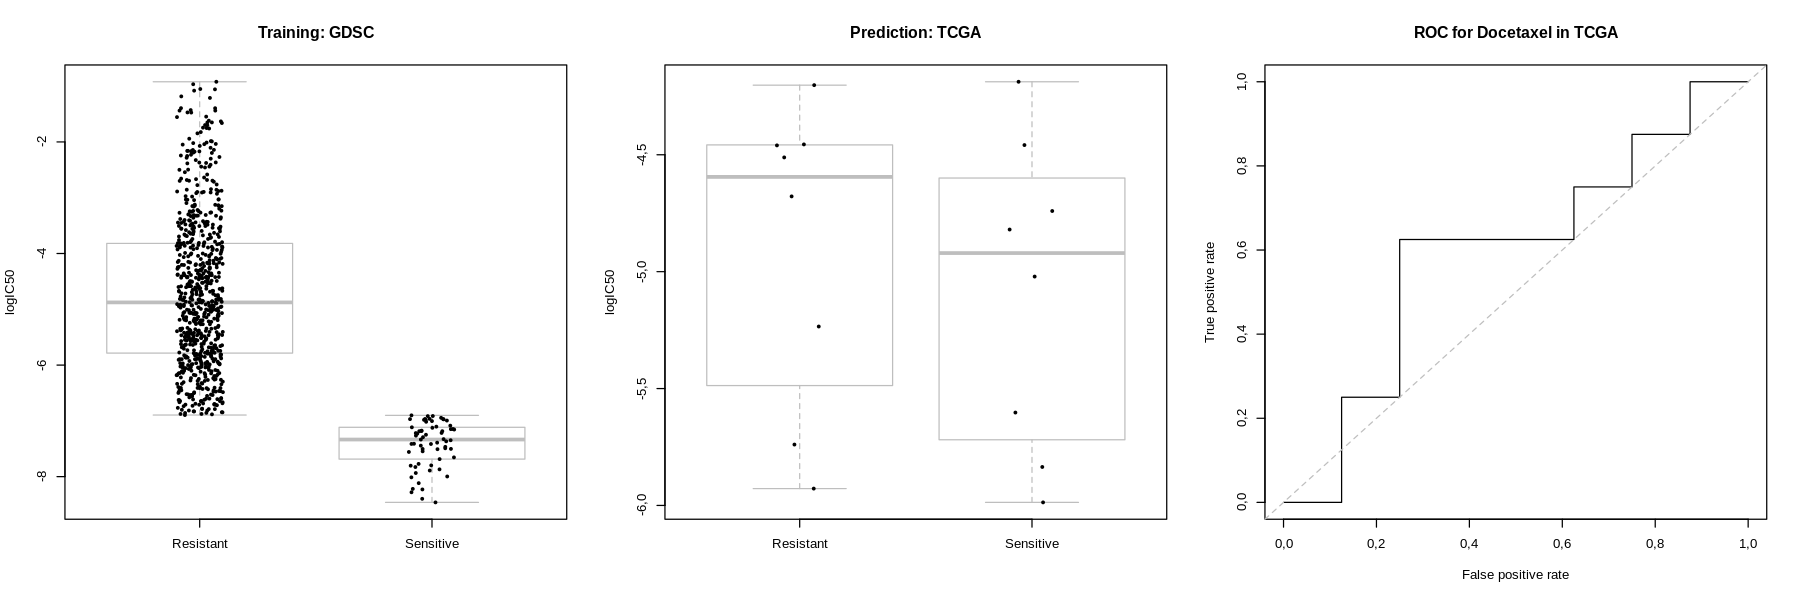



[1] "TCGA"        "Gemcitabine"
TCGA Gemcitabine
genes in training cohort: 18645	samples: 844
genes in testing cohort: 20531	samples: 57
shared:18216

AUC:    0,534391534391534
ROC Permuatation p-value:    0,3417
average AUC in permutations:    0,501050396825397


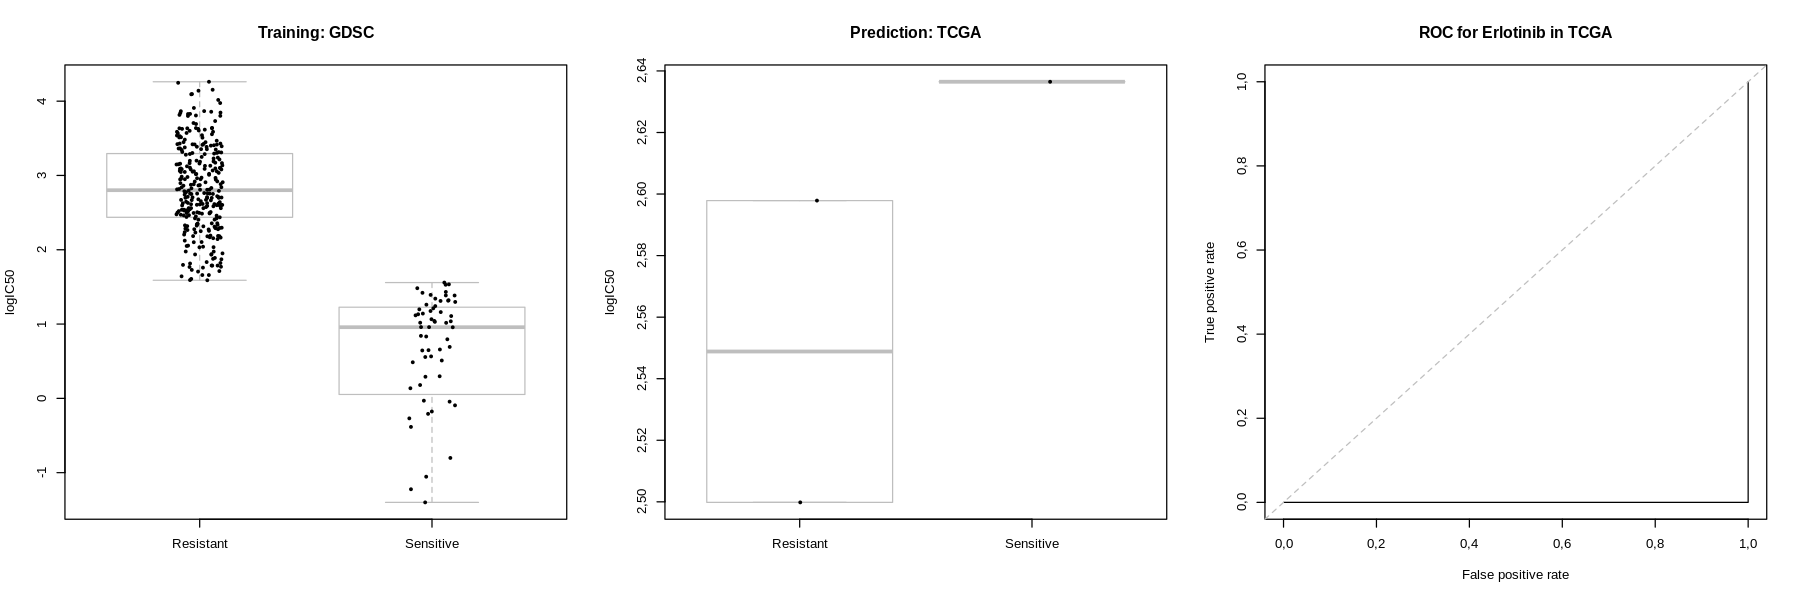



[1] "TCGA"       "Paclitaxel"
TCGA Paclitaxel
genes in training cohort: 18645	samples: 389
genes in testing cohort: 20531	samples: 35
shared:18216

AUC:    0,368
ROC Permuatation p-value:    0,8825
average AUC in permutations:    0,5011196


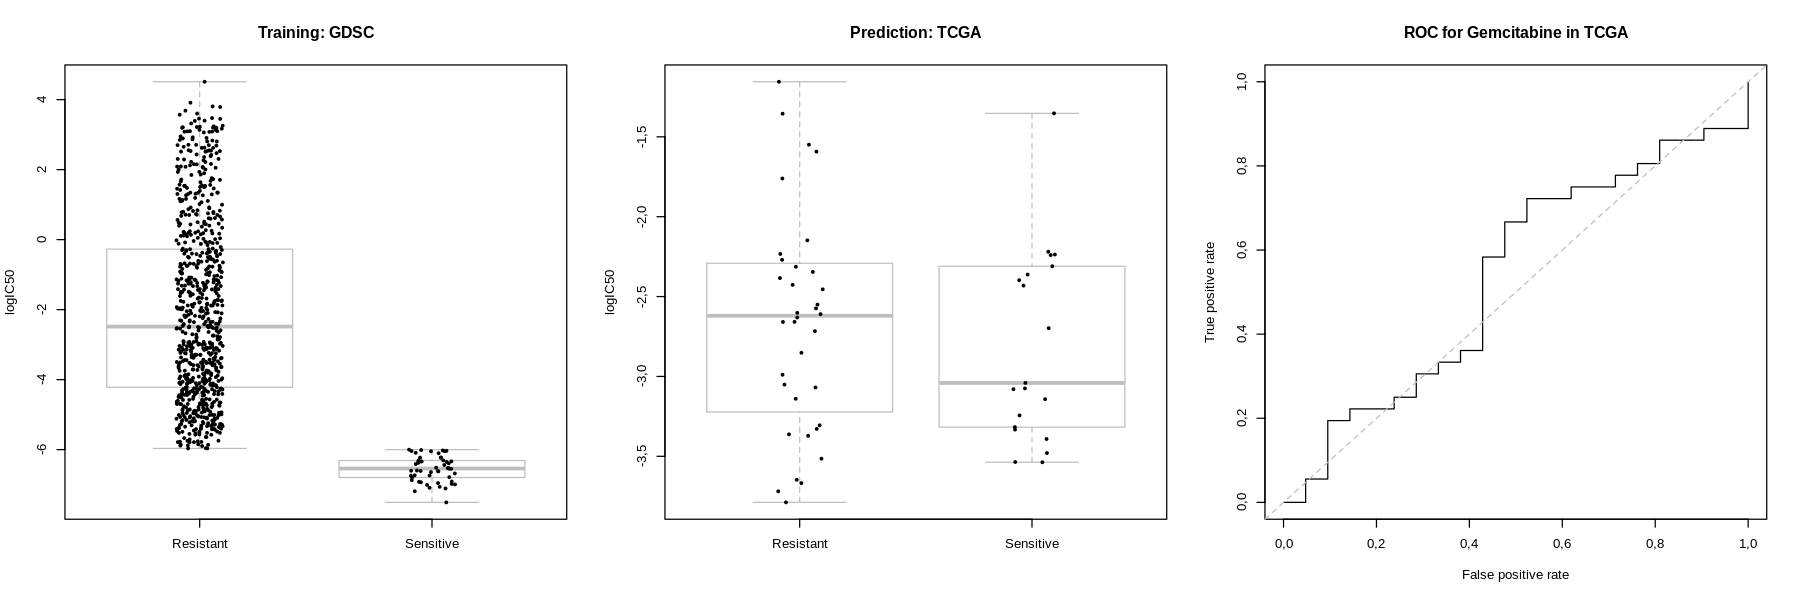



[1] "TCGA"      "Tamoxifen"
TCGA Tamoxifen
genes in training cohort: 18645	samples: 908
genes in testing cohort: 20531	samples: 13
shared:18216

AUC:    0,833333333333333
ROC Permuatation p-value:    0,042
average AUC in permutations:    0,50209


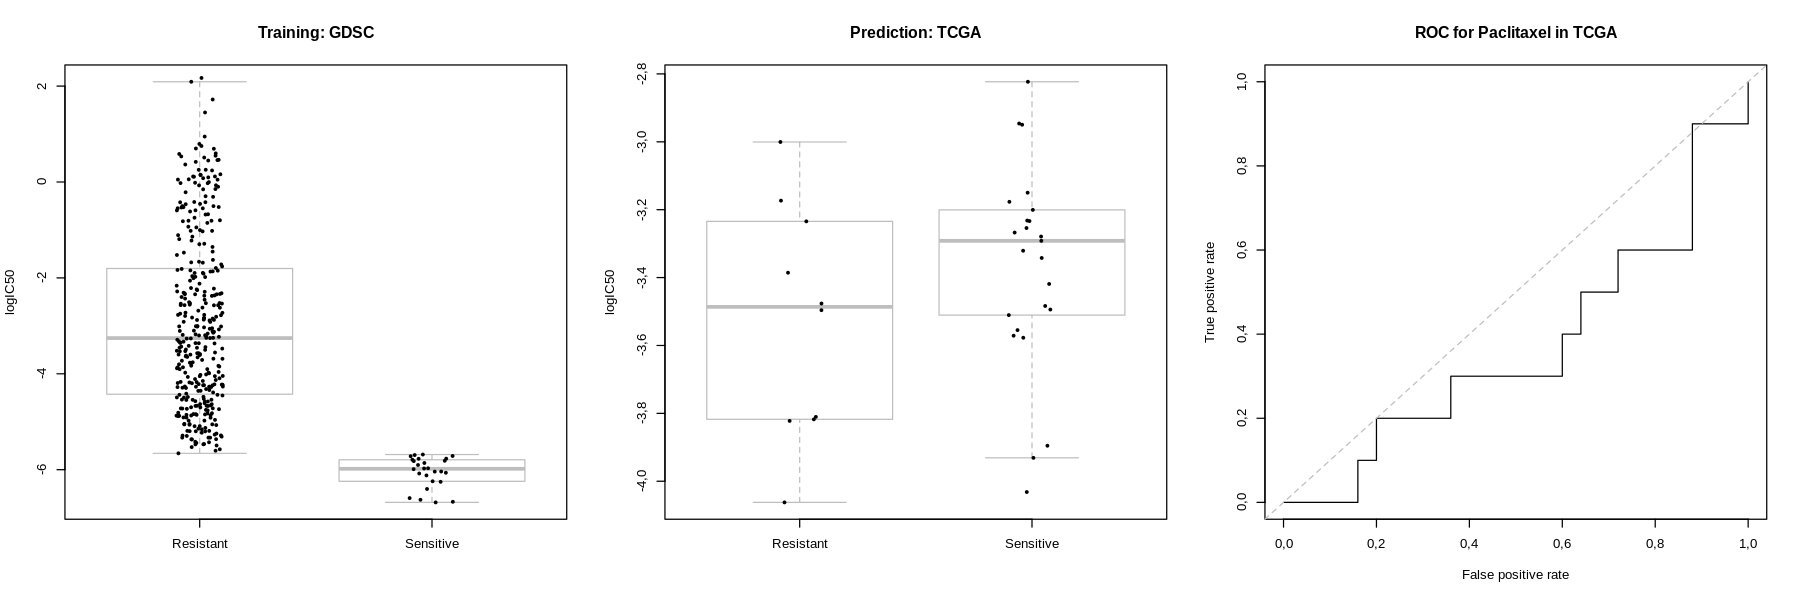

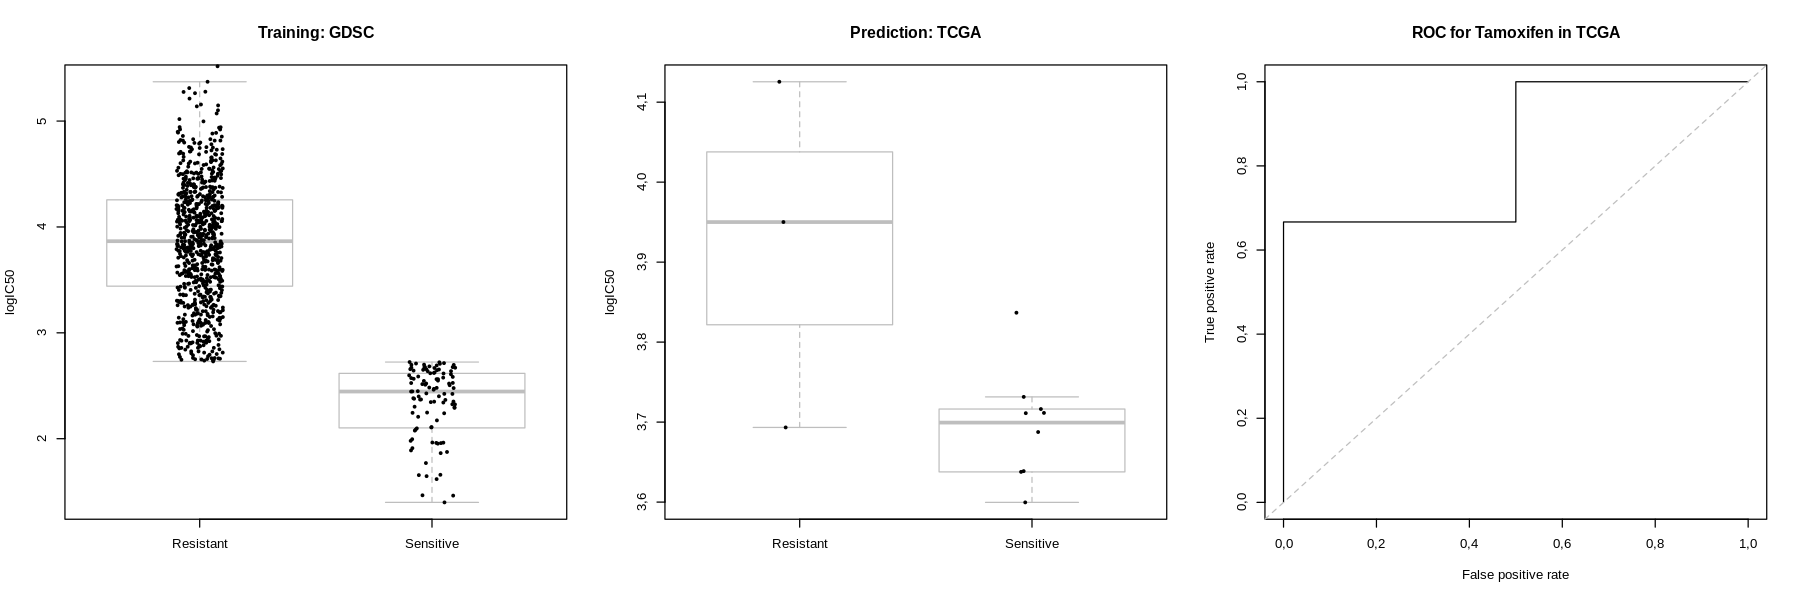

In [20]:
root_dir <- "/home/olya/SFU/Hossein/v2/"
for (fname in strsplit(list.files(paste0(root_dir,"/exprs/"),pattern = ".tsv"),".",fixed = T)){
    cohort <- sub("_exprs","",fname[1])
    drug <- fname[2]
    if (cohort != "CCLE" & cohort != "GDSC" & drug != "tsv" & drug != 'z' & drug != 'EGFRi' & drug != "Gefitinib"){
        print(c(cohort,drug))
        testDataFile <- paste0(root_dir,"/exprs/",cohort,"_exprs.",drug,".tsv")
        testResponseFile <- paste0(root_dir,"/response/",cohort,"_response.",drug,".tsv")

        trainingDataFile <- paste0(root_dir,"/exprs/","GDSC","_exprs.",drug,".tsv")
        trainingResponseFile <- paste0(root_dir,"/response/","GDSC","_response.",drug,".tsv")

        res <- run_Geelehers_method(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                           powTransP=powTransP,lowVarGeneThr=lowVarGeneThr,cohort=cohort,drug=drug)
    }
}

In [21]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/olya/miniconda2/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=de_DE.UTF-8       
 [3] LC_TIME=de_DE.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=de_DE.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=de_DE.UTF-8          LC_NAME=de_DE.UTF-8          
 [9] LC_ADDRESS=de_DE.UTF-8        LC_TELEPHONE=de_DE.UTF-8     
[11] LC_MEASUREMENT=de_DE.UTF-8    LC_IDENTIFICATION=de_DE.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] GEOquery_2.47.18      Biobase_2.36.2        BiocGenerics_0.22.1  
 [4] ROCR_1.0-7            gplots_3.0.1          preprocessCore_1.38.1
 [7] car_3.0-2             carData_3.0-2         sva_3.24.4           
[10] BiocParallel_1.10.1   genefilter_1.58.1     mgcv_1.